In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# Part I: Prepare the training/test set for protein secondary structure prediction

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Define a data loader function to parse the files and load sequences and labels

## Define a dictionary for the amino acids and the secondary structure classes

AMINO_ACIDS = 'ARNDCQEGHILKMFPSTWYV'
SECONDARY_STRUCTURES = 'CHE'
UNKNOWN_AMINO_ACID = 'X'

## Mapping to the dictionaries
amino_acid_mapping = {amino_acid: i for i, amino_acid in enumerate(AMINO_ACIDS)}
secondary_structure_mapping = {secondary_structure: i for i, secondary_structure in enumerate(SECONDARY_STRUCTURES)}

print("Amino Acids Mappring: \n", amino_acid_mapping)
print("Secondary Structure Mapping: \n", secondary_structure_mapping)

Amino Acids Mappring: 
 {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
Secondary Structure Mapping: 
 {'C': 0, 'H': 1, 'E': 2}


In [4]:
# One-hot encoding functions from Homework 2 but updated
def aa_one_hot_encode(amino_acid_seq):
    encoded = []
    for aa in amino_acid_seq:
        one_hot = np.zeros(len(AMINO_ACIDS))
        if aa in amino_acid_mapping:
            one_hot[amino_acid_mapping[aa]] = 1
        encoded.append(one_hot)
    return np.array(encoded)

def ss_one_hot_encode(ss_seq):
    encoded = []
    for ss in ss_seq:
        one_hot = np.zeros(len(SECONDARY_STRUCTURES))
        if ss in secondary_structure_mapping:
            one_hot[secondary_structure_mapping[ss]] = 1
        encoded.append(one_hot)
    return np.array(encoded)

In [5]:
# Load dataset
def data_loader(file_path):
    sequences, structures = [], []

    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i in range(2, len(lines), 4):
            sequences.append(lines[i].strip())
            structures.append(lines[i+1].strip())

    return sequences, structures

In [6]:
# Padding helper
def pad_3d(sequences, maxlen, num_features):
    padded = np.zeros((len(sequences), maxlen, num_features))
    for i, seq in enumerate(sequences):
        padded[i, :len(seq), :] = seq
    return padded

### Training Dataset Prep

In [9]:
train_path = "/content/drive/MyDrive/Machine_Learning/Homework_04/ss_train.txt"
#train_path = "/content/drive/MyDrive/ss_train.txt"
aa_seqs_train, ss_seqs_train = data_loader(train_path)

# Encode & collect valid sequences
x_encoded_train = []
y_encoded_train = []

for aa_seq, ss_seq in zip(aa_seqs_train, ss_seqs_train):
    if UNKNOWN_AMINO_ACID not in aa_seq:
        x_encoded_train.append(aa_one_hot_encode(aa_seq))
        y_encoded_train.append(ss_one_hot_encode(ss_seq))

# Padding
max_seq_len = max(len(seq) for seq in x_encoded_train)  # or set manually
x_data = pad_3d(x_encoded_train, max_seq_len, len(AMINO_ACIDS))
y_data = pad_3d(y_encoded_train, max_seq_len, len(SECONDARY_STRUCTURES))

# Train/Validation split
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

### Test Dataset Prep

In [10]:
test_path = "/content/drive/MyDrive/Machine_Learning/Homework_04/ss_test.txt"
#test_path = "/content/drive/MyDrive/ss_test.txt"
aa_seqs_test, ss_seqs_test = data_loader(test_path)

x_encoded_test = []
y_encoded_test = []

for aa_seq, ss_seq in zip(aa_seqs_test, ss_seqs_test):
    if UNKNOWN_AMINO_ACID not in aa_seq:
        x_encoded_test.append(aa_one_hot_encode(aa_seq))
        y_encoded_test.append(ss_one_hot_encode(ss_seq))

x_test = pad_3d(x_encoded_test, max_seq_len, len(AMINO_ACIDS))
y_test = pad_3d(y_encoded_test, max_seq_len, len(SECONDARY_STRUCTURES))

In [11]:
# Expected shape should have (number of samples, sequence length, num_features)
# Sequence length is the number of amino acids in each sequence for input.
# Number of features is determined based on the number of amino acids for input.
# Number of features is determined based on the number of secondary structure classes for output.

print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)

print("x_val.shape:", x_val.shape)
print("y_val.shape:", y_val.shape)

print("x_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

x_train.shape: (932, 1231, 20)
y_train.shape: (932, 1231, 3)
x_val.shape: (234, 1231, 20)
y_val.shape: (234, 1231, 3)
x_test.shape: (124, 1231, 20)
y_test.shape: (124, 1231, 3)


# Part II: Apply Recurrent Neural Network on protein secondary structure prediction

In [12]:
# Define function to build different RNN models based on the arguments provided for the input shape, number of neurons, and number of classes.

import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Dense, Masking

def build_model(rnn_type = "SimpleRNN", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2):
    model = keras.Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape = input_shape))

    if rnn_type == "SimpleRNN":
        model.add(layers.SimpleRNN(no_hidden_neurons, activation='relu', return_sequences=True))
        model.add(layers.Dropout(dropout_rate))
    elif rnn_type == "LSTM":
        model.add(layers.LSTM(no_hidden_neurons, activation='relu', return_sequences=True))
        model.add(layers.Dropout(dropout_rate))
    elif rnn_type == "GRU":
        model.add(layers.GRU(no_hidden_neurons, activation='relu', return_sequences=True))
        model.add(layers.Dropout(dropout_rate))
    else:
        raise ValueError("Invalid RNN type. Choose from 'SimpleRNN', 'LSTM', or 'GRU'.")

    model.add((Dense(num_classes, activation='softmax')))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

In [13]:
# Define function to evaluate the model using accuracy, F1, precision and recall

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

def evaluate_model(model, x_train, y_train, x_val, y_val, x_test, y_test):
    # Predictions (as class indices)
    y_train_pred = np.argmax(model.predict(x_train), axis=-1).flatten()
    y_val_pred = np.argmax(model.predict(x_val), axis=-1).flatten()
    y_test_pred = np.argmax(model.predict(x_test), axis=-1).flatten()

    # True labels (as class indices)
    y_train_true = np.argmax(y_train, axis=-1).flatten()
    y_val_true = np.argmax(y_val, axis=-1).flatten()
    y_test_true = np.argmax(y_test, axis=-1).flatten()

    # Calculate accuracy_score, f1_score, precision and recall for the training, validation and test dataset

    train_accuracy = accuracy_score(y_train_true, y_train_pred)
    val_accuracy = accuracy_score(y_val_true, y_val_pred)
    test_accuracy = accuracy_score(y_test_true, y_test_pred)

    train_f1 = f1_score(y_train_true, y_train_pred, average='weighted')
    val_f1 = f1_score(y_val_true, y_val_pred, average='weighted')
    test_f1 = f1_score(y_test_true, y_test_pred, average='weighted')

    train_precision = precision_score(y_train_true, y_train_pred, average='weighted', zero_division=0)
    val_precision = precision_score(y_val_true, y_val_pred, average='weighted', zero_division=0)
    test_precision = precision_score(y_test_true, y_test_pred, average='weighted', zero_division=0)

    train_recall = recall_score(y_train_true, y_train_pred, average='weighted')
    val_recall = recall_score(y_val_true, y_val_pred, average='weighted')
    test_recall = recall_score(y_test_true, y_test_pred, average='weighted')

    # Add all scores to a dictionary and return it
    scores = {
        'train_accuracy': train_accuracy,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'train_f1': train_f1,
        'val_f1': val_f1,
        'test_f1': test_f1,
        'train_precision': train_precision,
        'val_precision': val_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'val_recall': val_recall,
        'test_recall': test_recall
    }

    return scores

In [14]:
def print_scores(scores_dict, title=None):
    if title:
        print(f"\n{title}")
        print("-" * len(title))

    max_key_len = max(len(key) for key in scores_dict.keys())
    for key, value in scores_dict.items():
        print(f"{key.ljust(max_key_len)} : {value:.4f}")

## TASK 1

### Simple RNN architecture

In [15]:
simple_rnn_model = build_model(rnn_type = "SimpleRNN", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking (Masking)                    │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 1231, 32)            │           1,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1231, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1231, 3)             │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,795 (7.01 KB)

 Trainable params: 1,795 (7.01 KB)

 Non-trainable params: 0 (0.00 B)

### LSTM architecture

In [16]:
lstm_model = build_model(rnn_type = "LSTM", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 1231, 32)            │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1231, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1231, 3)             │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,883 (26.89 KB)

 Trainable params: 6,883 (26.89 KB)

 Non-trainable params: 0 (0.00 B)

### GRU architecture

In [17]:
gru_model = build_model(rnn_type = "GRU", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 1231, 32)            │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1231, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1231, 3)             │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,283 (20.64 KB)

 Trainable params: 5,283 (20.64 KB)

 Non-trainable params: 0 (0.00 B)

## TASK 2: Create a simulated dataset to test the performance of the three models

In [18]:
import numpy as np
import tensorflow as tf
import keras
from keras import utils

N = 100
L = 1231
D = 20 # input features
C = 3 # number of output calsses

x_sim = np.random.rand(N, L, D).astype(np.float32)
y_sim = np.random.randint(3, size=(N, L))
y_sim = tf.keras.utils.to_categorical(y_sim, num_classes = C)

In [19]:
print("x_sim.shape:", x_sim.shape)
print("y_sim.shape:", y_sim.shape)

x_sim.shape: (100, 1231, 20)
y_sim.shape: (100, 1231, 3)


### Train the simple RNN architecture with simulated dataset

In [20]:
simple_rnn_model.fit(x_sim, y_sim, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.3352 - loss: 1.6088 - val_accuracy: 0.3337 - val_loss: 1.5153
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - accuracy: 0.3350 - loss: 1.5402 - val_accuracy: 0.3333 - val_loss: 1.4521
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step - accuracy: 0.3350 - loss: 1.4774 - val_accuracy: 0.3325 - val_loss: 1.3936
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step - accuracy: 0.3342 - loss: 1.4227 - val_accuracy: 0.3333 - val_loss: 1.3407
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - accuracy: 0.3352 - loss: 1.3676 - val_accuracy: 0.3328 - val_loss: 1.2943
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step - accuracy: 0.3342 - loss: 1.3232 - val_accuracy: 0.3324 - val_loss: 1.2551
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3353 - loss: 1.2841 - val_accuracy: 0.3327 - val_loss: 1.2230
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3357 - loss: 1.2538 - val_accuracy: 0.3326 - val_loss: 1.1973
E

### Train the LSTM architecture with simulated dataset

In [21]:
lstm_model.fit(x_sim, y_sim, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3348 - loss: 1.1166 - val_accuracy: 0.3336 - val_loss: 1.1060
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 0.3339 - loss: 1.1109 - val_accuracy: 0.3342 - val_loss: 1.1023
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3334 - loss: 1.1064 - val_accuracy: 0.3383 - val_loss: 1.1002
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3329 - loss: 1.1045 - val_accuracy: 0.3396 - val_loss: 1.0993
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step - accuracy: 0.3340 - loss: 1.1031 - val_accuracy: 0.3339 - val_loss: 1.0993
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3327 - loss: 1.1031 - val_accuracy: 0.3318 - val_loss: 1.0998
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3310 - loss: 1.1038 - val_accuracy: 0.3306 - val_loss: 1.1002
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3342 - loss: 1.1037 - val_accuracy: 0.3312 - val_loss: 1.1003
Epoch 9/10

### Train the GRU architecture with the simulated dataset

In [22]:
gru_model.fit(x_sim, y_sim, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3313 - loss: 1.1510 - val_accuracy: 0.3352 - val_loss: 1.1292
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3316 - loss: 1.1434 - val_accuracy: 0.3347 - val_loss: 1.1229
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3310 - loss: 1.1360 - val_accuracy: 0.3346 - val_loss: 1.1176
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3309 - loss: 1.1304 - val_accuracy: 0.3321 - val_loss: 1.1134
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3307 - loss: 1.1256 - val_accuracy: 0.3312 - val_loss: 1.1100
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3331 - loss: 1.1211 - val_accuracy: 0.3281 - val_loss: 1.1074
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3311 - loss: 1.1190 - val_accuracy: 0.3289 - val_loss: 1.1054
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3311 - loss: 1.1165 - val_accuracy: 0.3296 - val_loss: 1.1040
Epoch 9/10
1/1 ━

## TASK 3: Build and train the three models with original dataset

### Train the simple RNN architecture with original dataset

In [23]:
simple_rnn_model_1 = build_model(rnn_type = "SimpleRNN", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 1231, 32)            │           1,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1231, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1231, 3)             │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,795 (7.01 KB)

 Trainable params: 1,795 (7.01 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
simple_rnn_model_1.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 478ms/step - accuracy: 0.1920 - loss: 1.1327 - val_accuracy: 0.3900 - val_loss: 1.0765
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 548ms/step - accuracy: 0.4781 - loss: 1.0748 - val_accuracy: 0.5972 - val_loss: 1.0552
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 532ms/step - accuracy: 0.5976 - loss: 1.0590 - val_accuracy: 0.6195 - val_loss: 1.0420
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 406ms/step - accuracy: 0.5901 - loss: 1.0446 - val_accuracy: 0.5780 - val_loss: 1.0297
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 544ms/step - accuracy: 0.5941 - loss: 1.0285 - val_accuracy: 0.5932 - val_loss: 1.0163
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 467ms/step - accuracy: 0.5796 - loss: 1.0211 - val_accuracy: 0.5721 - val_loss: 1.0008
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 416ms/step - accuracy: 0.5304 - loss: 1.0021 - val_accuracy: 0.5728 - val_loss: 0.9832
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.5621 - loss: 0.9943 - val_accuracy: 0.563

In [25]:
# Get the evaluation metrics

simple_rnn_scores = evaluate_model(simple_rnn_model_1, x_train, y_train, x_val, y_val, x_test, y_test)
print_scores(simple_rnn_scores, title="Simple RNN Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step

Simple RNN Model Evaluation Metrics
-----------------------------------
train_accuracy  : 0.5750
val_accuracy    : 0.5633
test_accuracy   : 0.6099
train_f1        : 0.6593
val_f1          : 0.6482
test_f1         : 0.7033
train_precision : 0.8194
val_precision   : 0.8132
test_precision  : 0.8640
train_recall    : 0.5750
val_recall      : 0.5633
test_recall     : 0.6099


### Train the LSTM architecture with original dataset

In [26]:
lstm_model_1 = build_model(rnn_type = "LSTM", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_4 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 1231, 32)            │           6,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1231, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1231, 3)             │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,883 (26.89 KB)

 Trainable params: 6,883 (26.89 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
lstm_model_1.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 856ms/step - accuracy: 0.5013 - loss: 1.0888 - val_accuracy: 0.8864 - val_loss: 1.0646
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 859ms/step - accuracy: 0.8818 - loss: 1.0616 - val_accuracy: 0.8794 - val_loss: 1.0545
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 839ms/step - accuracy: 0.7944 - loss: 1.0536 - val_accuracy: 0.7625 - val_loss: 1.0474
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - accuracy: 0.7298 - loss: 1.0455 - val_accuracy: 0.7382 - val_loss: 1.0386
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - accuracy: 0.6727 - loss: 1.0345 - val_accuracy: 0.5991 - val_loss: 1.0275
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 998ms/step - accuracy: 0.5946 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 877ms/step - accuracy: 0.8883 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 906ms/step - accuracy: 0.8839 - loss: nan - val_accuracy: 0.8866 - val_loss

In [28]:
lstm_scores = evaluate_model(lstm_model_1, x_train, y_train, x_val, y_val, x_test, y_test)
print_scores(lstm_scores, title="LSTM Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

LSTM Model Evaluation Metrics
-----------------------------
train_accuracy  : 0.8884
val_accuracy    : 0.8866
test_accuracy   : 0.9192
train_f1        : 0.8359
val_f1          : 0.8332
test_f1         : 0.8804
train_precision : 0.7893
val_precision   : 0.7860
test_precision  : 0.8449
train_recall    : 0.8884
val_recall      : 0.8866
test_recall     : 0.9192


### Train the GRU architecture with original dataset

In [29]:
gru_model_1 = build_model(rnn_type = "GRU", input_shape = (1231, 20), no_hidden_neurons = 32, num_classes = 3, dropout_rate = 0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_5 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 1231, 32)            │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1231, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1231, 3)             │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,283 (20.64 KB)

 Trainable params: 5,283 (20.64 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
gru_model_1.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 18s 970ms/step - accuracy: 0.2780 - loss: 1.0793 - val_accuracy: 0.5371 - val_loss: 1.0600
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 894ms/step - accuracy: 0.5868 - loss: 1.0572 - val_accuracy: 0.7328 - val_loss: 1.0427
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 987ms/step - accuracy: 0.6908 - loss: 1.0420 - val_accuracy: 0.7218 - val_loss: 1.0302
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 935ms/step - accuracy: 0.6617 - loss: 1.0282 - val_accuracy: 0.6660 - val_loss: 1.0178
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 986ms/step - accuracy: 0.6336 - loss: 1.0210 - val_accuracy: 0.6332 - val_loss: 1.0038
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 15s 981ms/step - accuracy: 0.5569 - loss: 1.0069 - val_accuracy: 0.5938 - val_loss: 0.9891
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 963ms/step - accuracy: 0.5455 - loss: 0.9958 - val_accuracy: 0.5472 - val_loss: 0.9734
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 987ms/step - accuracy: 0.5430 - loss: 0.9837 - val_accuracy: 0.

In [31]:
gru_scores = evaluate_model(gru_model_1, x_train, y_train, x_val, y_val, x_test, y_test)
print_scores(gru_scores, title="GRU Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step

GRU Model Evaluation Metrics
----------------------------
train_accuracy  : 0.4908
val_accuracy    : 0.5222
test_accuracy   : 0.5034
train_f1        : 0.5882
val_f1          : 0.6146
test_f1         : 0.6173
train_precision : 0.8162
val_precision   : 0.8189
test_precision  : 0.8593
train_recall    : 0.4908
val_recall      : 0.5222
test_recall     : 0.5034


### Visualize performance of all models

In [32]:
import matplotlib.pyplot as plt

def plot_model_metrics(models_results, model_names):
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    sets = ['train', 'val', 'test']

    for metric in metrics:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'{metric.capitalize()} Comparison Across Models', fontsize=18)

        for i, dataset in enumerate(sets):
            scores = []
            for result in models_results:
                key = f"{dataset}_{metric}"
                scores.append(result.get(key, 0.0))  # default to 0.0 if missing

            axes[i].plot(model_names, scores, color='blue', marker='x', linestyle='-')
            axes[i].set_ylim(0, 1)
            axes[i].set_title(f"{dataset.capitalize()} Set")
            axes[i].set_ylabel(metric.capitalize())
            axes[i].set_xlabel("Models")
            for j, val in enumerate(scores):
                axes[i].text(j, val + 0.01, f"{val:.2f}", ha='center', fontsize=10)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

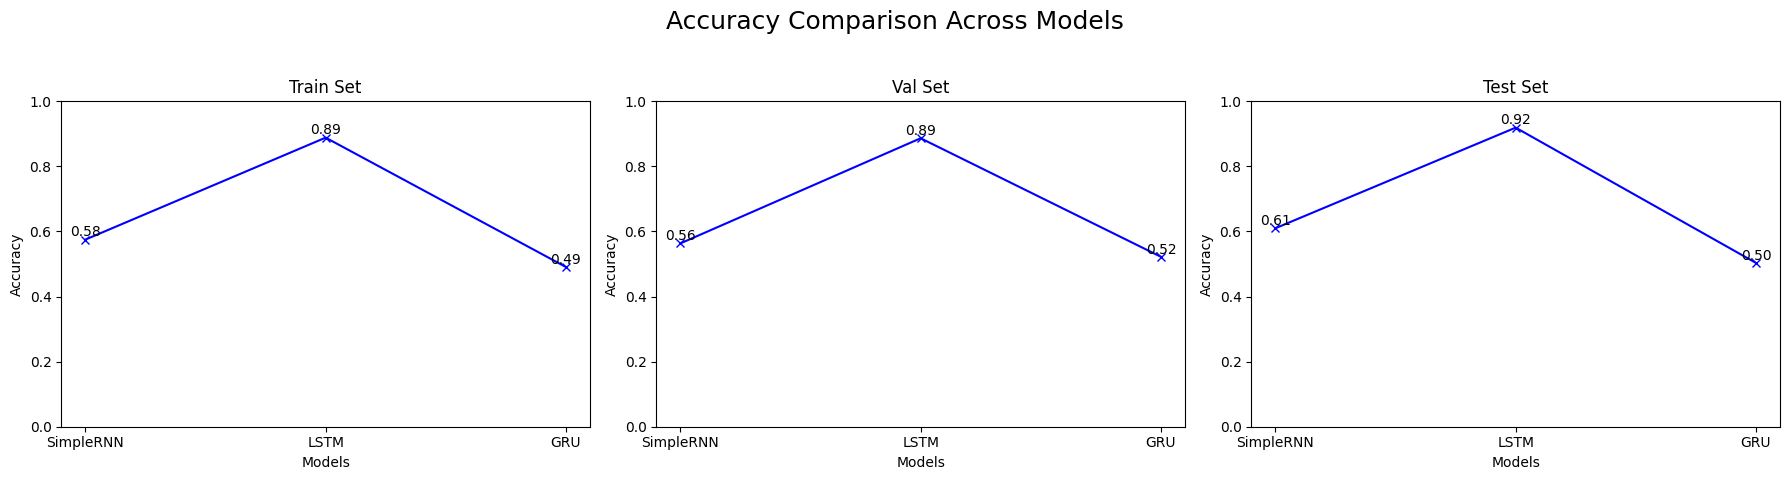

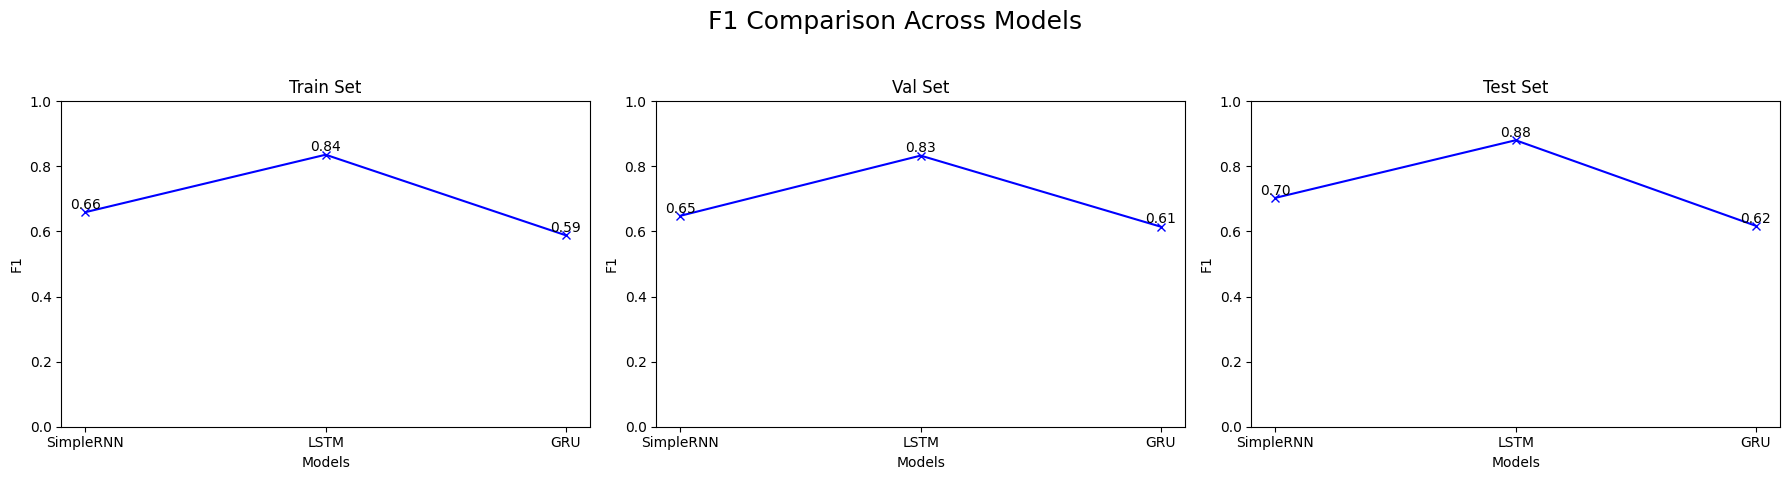

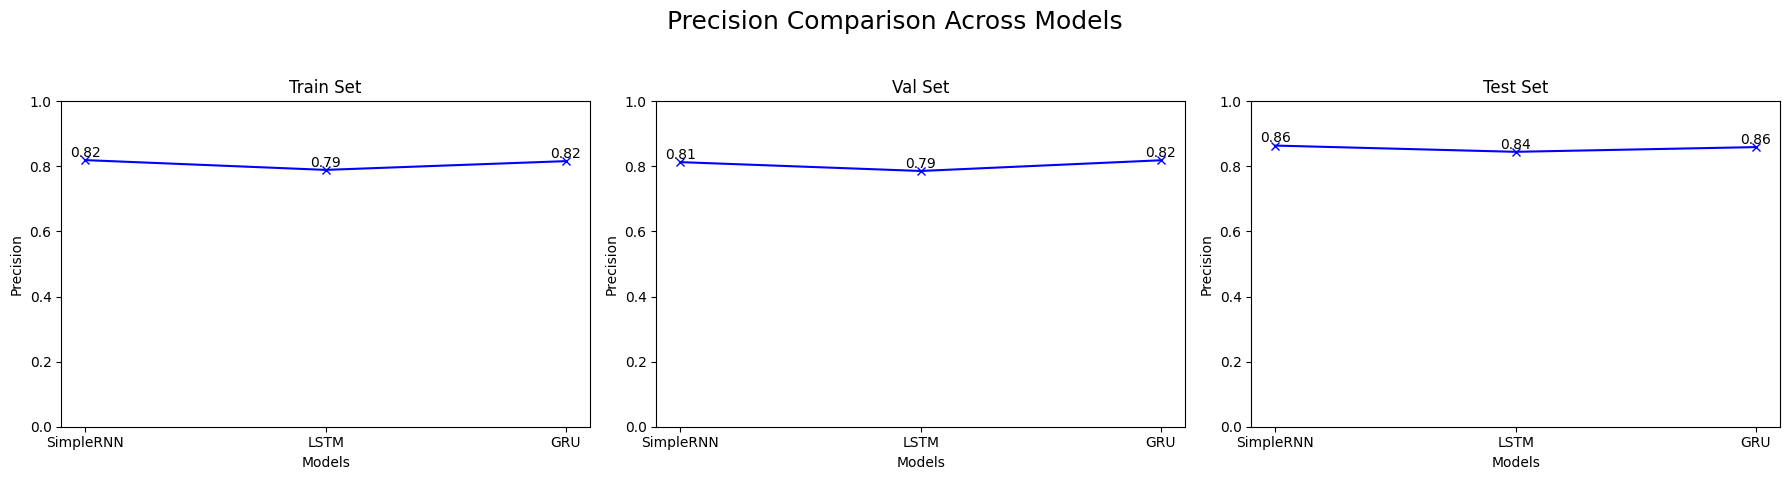

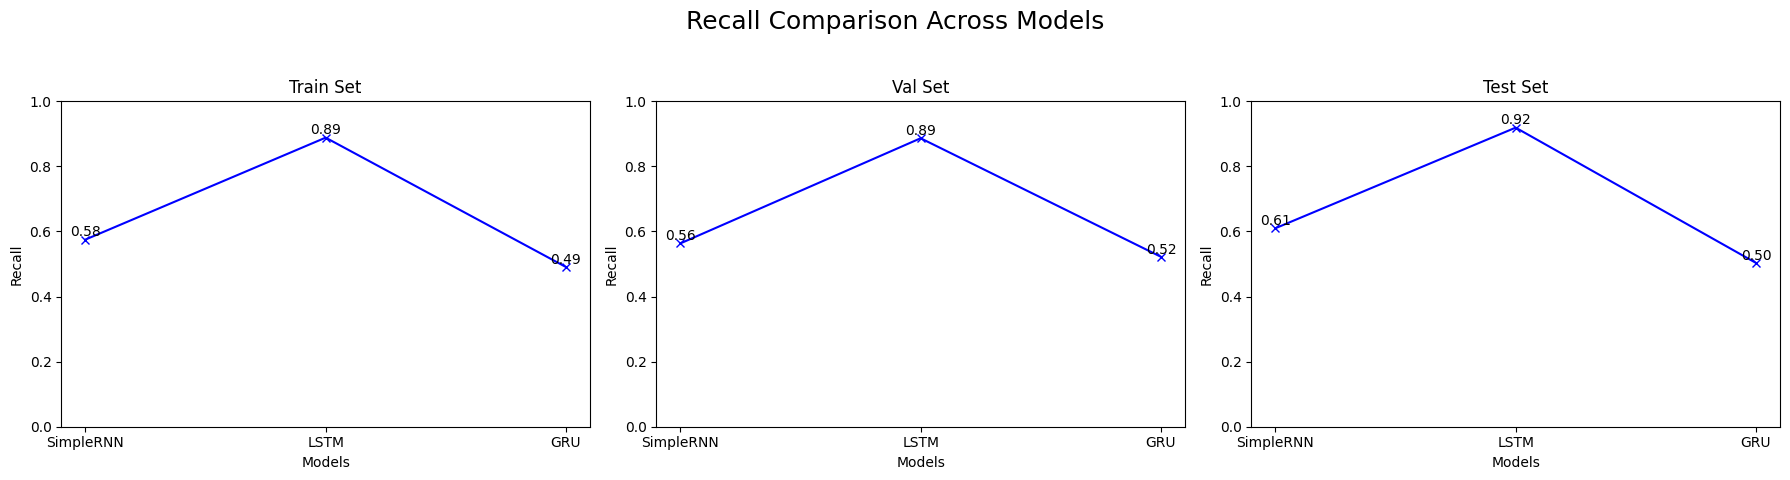

In [33]:
models_results = [simple_rnn_scores, lstm_scores, gru_scores]
model_names = ['SimpleRNN', 'LSTM', 'GRU']

plot_model_metrics(models_results, model_names)

# TASK 4: Advanced architecture using Bi-directional RNN/LSTM/GRU

In [34]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Dense, Masking, Dropout, Bidirectional

def build_model(rnn_type="SimpleRNN", input_shape=(1231, 20), no_hidden_neurons=32,
                num_classes=3, dropout_rate=0.2, bidirectional=False):


    model = keras.Sequential()
    model.add(layers.Masking(mask_value=0.0, input_shape=input_shape))  # Masking for padded sequences

    # Choose RNN Type
    if rnn_type == "SimpleRNN":
        rnn_layer = layers.SimpleRNN(no_hidden_neurons, activation='relu', return_sequences=True)
    elif rnn_type == "LSTM":
        rnn_layer = layers.LSTM(no_hidden_neurons, activation='relu', return_sequences=True)
    elif rnn_type == "GRU":
        rnn_layer = layers.GRU(no_hidden_neurons, activation='relu', return_sequences=True)
    else:
        raise ValueError("Invalid RNN type. Choose from 'SimpleRNN', 'LSTM', or 'GRU'.")

    # Apply bidirectionality if selected
    if bidirectional:
        model.add(Bidirectional(rnn_layer))
    else:
        model.add(rnn_layer)

    # Add dropout layer for regularization
    model.add(Dropout(dropout_rate))

    # Output layer for classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model


###Train the Bi directional Simple RNN architecture with original dataset

In [35]:
model_birnn = build_model(rnn_type="SimpleRNN", input_shape=(1231, 20), no_hidden_neurons=64, num_classes=3, bidirectional=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1231, 128)           │          10,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1231, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1231, 3)             │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,267 (44.01 KB)

 Trainable params: 11,267 (44.01 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_birnn.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8286 - loss: 1.1070 - val_accuracy: 0.0947 - val_loss: 1.0360
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.1663 - loss: 1.0359 - val_accuracy: 0.9068 - val_loss: 0.9971
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.9058 - loss: 0.9907 - val_accuracy: 0.9120 - val_loss: 0.9445
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9140 - loss: 0.9404 - val_accuracy: 0.9169 - val_loss: 0.9070
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9154 - loss: 0.9111 - val_accuracy: 0.9206 - val_loss: 0.8831
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9190 - loss: 0.8959 - val_accuracy: 0.9222 - val_loss: 0.8682
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9233 - loss: 0.8716 - val_accuracy: 0.9242 - val_loss: 0.8523
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9219 - loss: 0.8691 - val_accuracy: 0.9243 - val_loss: 0.8500


In [37]:
birnn_scores = evaluate_model(model_birnn, x_train, y_train, x_val, y_val, x_test, y_test)
print_scores(birnn_scores, title="BiRNN Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step

BiRNN Model Evaluation Metrics
------------------------------
train_accuracy  : 0.9262
val_accuracy    : 0.9243
test_accuracy   : 0.9422
train_f1        : 0.9238
val_f1          : 0.9220
test_f1         : 0.9403
train_precision : 0.9252
val_precision   : 0.9233
test_precision  : 0.9412
train_recall    : 0.9262
val_recall      : 0.9243
test_recall     : 0.9422


###Train the Bi directional LSTM architecture with original dataset

In [38]:
model_bilstm = build_model(rnn_type="LSTM", input_shape=(1231, 20), no_hidden_neurons=64, num_classes=3, bidirectional=True)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_7 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1231, 128)           │          43,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1231, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1231, 3)             │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,907 (171.51 KB)

 Trainable params: 43,907 (171.51 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model_bilstm.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6918 - loss: 1.0878 - val_accuracy: 0.8865 - val_loss: 1.0536
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.2586 - loss: 1.0492 - val_accuracy: 0.1040 - val_loss: 1.0386
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6140 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8897 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.8875 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8888 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8896 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8856 - loss: nan - val_accuracy: 0.8866 - val_loss: nan


In [40]:
bilstm_scores = evaluate_model(model_bilstm, x_train, y_train, x_val, y_val, x_test, y_test)
print_scores(bilstm_scores, title="BiLSTM Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 376ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step

BiLSTM Model Evaluation Metrics
-------------------------------
train_accuracy  : 0.8884
val_accuracy    : 0.8866
test_accuracy   : 0.9192
train_f1        : 0.8359
val_f1          : 0.8332
test_f1         : 0.8804
train_precision : 0.7893
val_precision   : 0.7860
test_precision  : 0.8449
train_recall    : 0.8884
val_recall      : 0.8866
test_recall     : 0.9192


###Train the Bi directional GRU architecture with original dataset

In [41]:
model_bigru = build_model(rnn_type="GRU", input_shape=(1231, 20), no_hidden_neurons=64, num_classes=3, bidirectional=True)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_8 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1231, 128)           │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1231, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1231, 3)             │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,411 (130.51 KB)

 Trainable params: 33,411 (130.51 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_bigru.fit(x_train, y_train, epochs=8, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8831 - loss: 1.0873 - val_accuracy: 0.8871 - val_loss: 1.0512
Epoch 2/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8952 - loss: 1.0440 - val_accuracy: 0.9063 - val_loss: 1.0288
Epoch 3/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9045 - loss: 1.0238 - val_accuracy: 0.9081 - val_loss: 1.0031
Epoch 4/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9078 - loss: 0.9984 - val_accuracy: 0.9078 - val_loss: 0.9715
Epoch 5/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9108 - loss: 0.9629 - val_accuracy: 0.9158 - val_loss: 0.9283
Epoch 6/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9105 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 7/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8867 - loss: nan - val_accuracy: 0.8866 - val_loss: nan
Epoch 8/8
15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.8868 - loss: nan - val_accuracy: 0.8866 - val_loss: nan


In [43]:
bigru_scores = evaluate_model(model_bigru, x_train, y_train, x_val, y_val, x_test, y_test)
print_scores(bigru_scores, title="BiGRU Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 344ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 260ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step

BiGRU Model Evaluation Metrics
------------------------------
train_accuracy  : 0.8884
val_accuracy    : 0.8866
test_accuracy   : 0.9192
train_f1        : 0.8359
val_f1          : 0.8332
test_f1         : 0.8804
train_precision : 0.7893
val_precision   : 0.7860
test_precision  : 0.8449
train_recall    : 0.8884
val_recall      : 0.8866
test_recall     : 0.9192


###Visualize performance of Basic model with Bidirectional layer

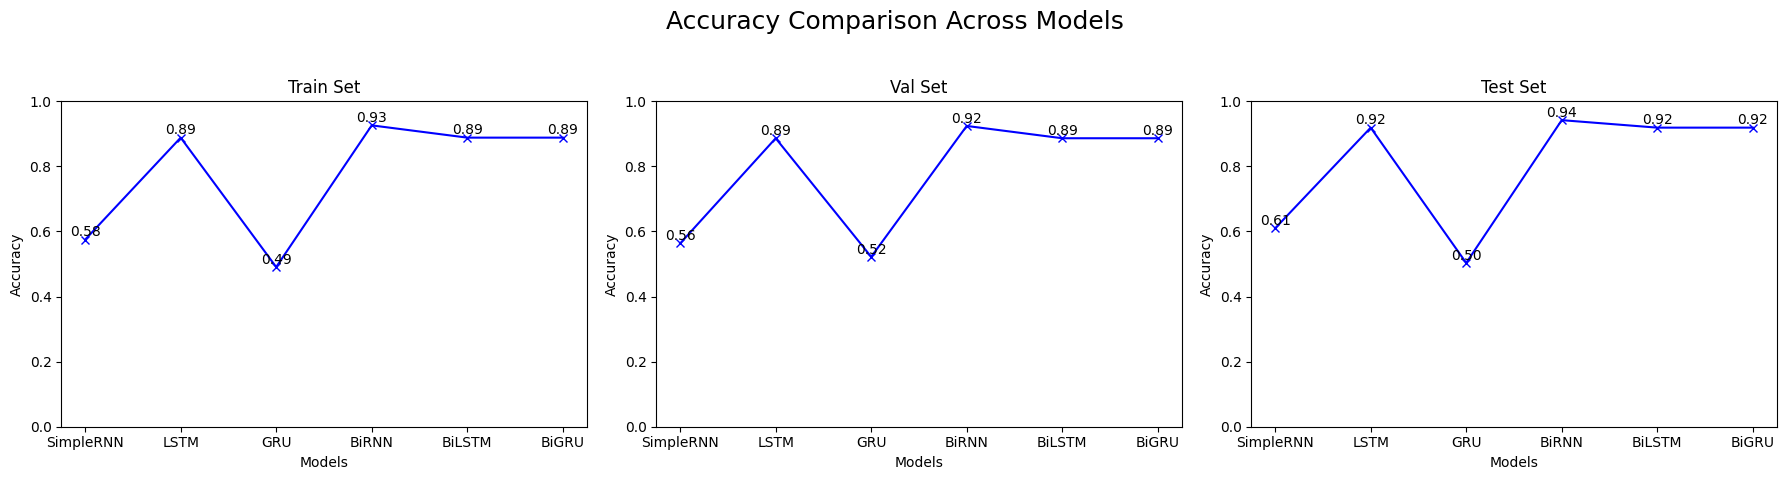

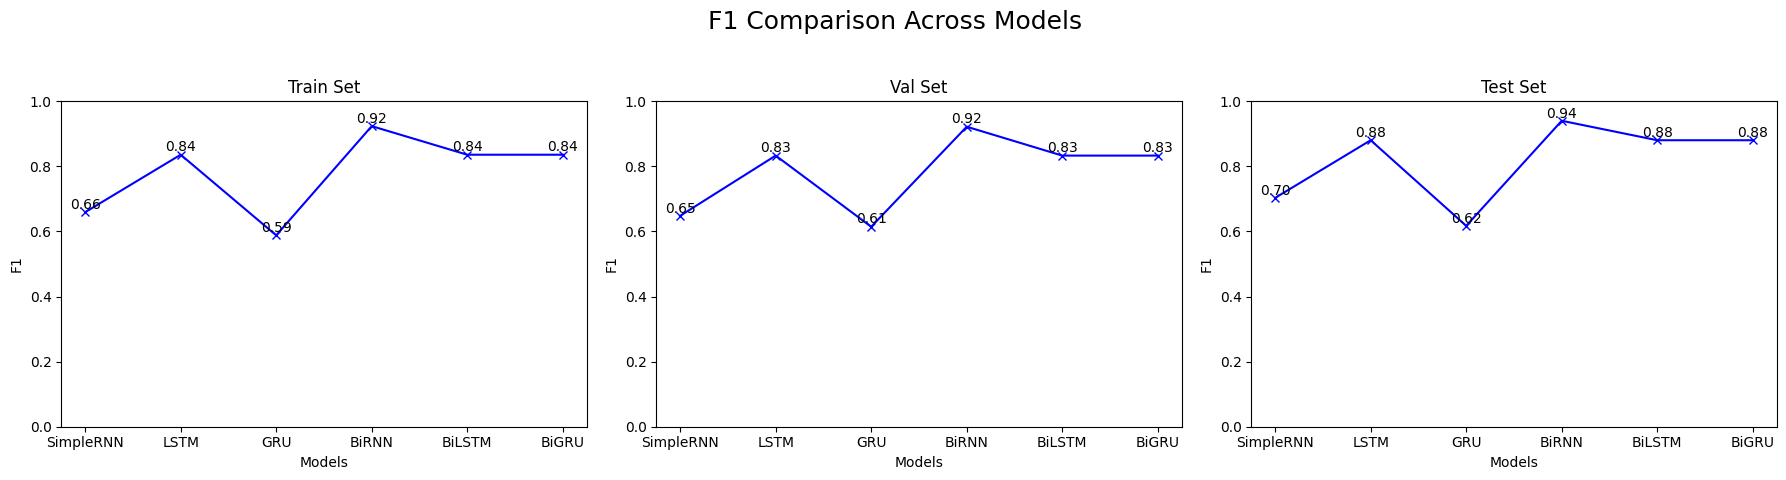

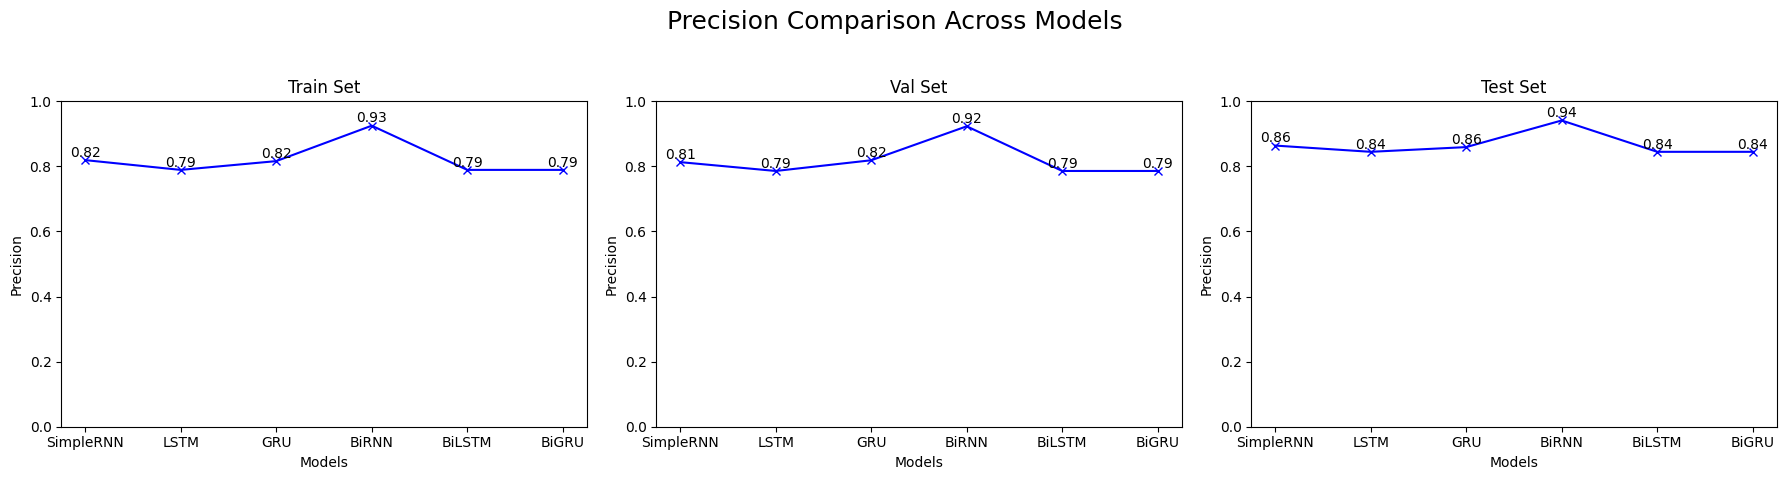

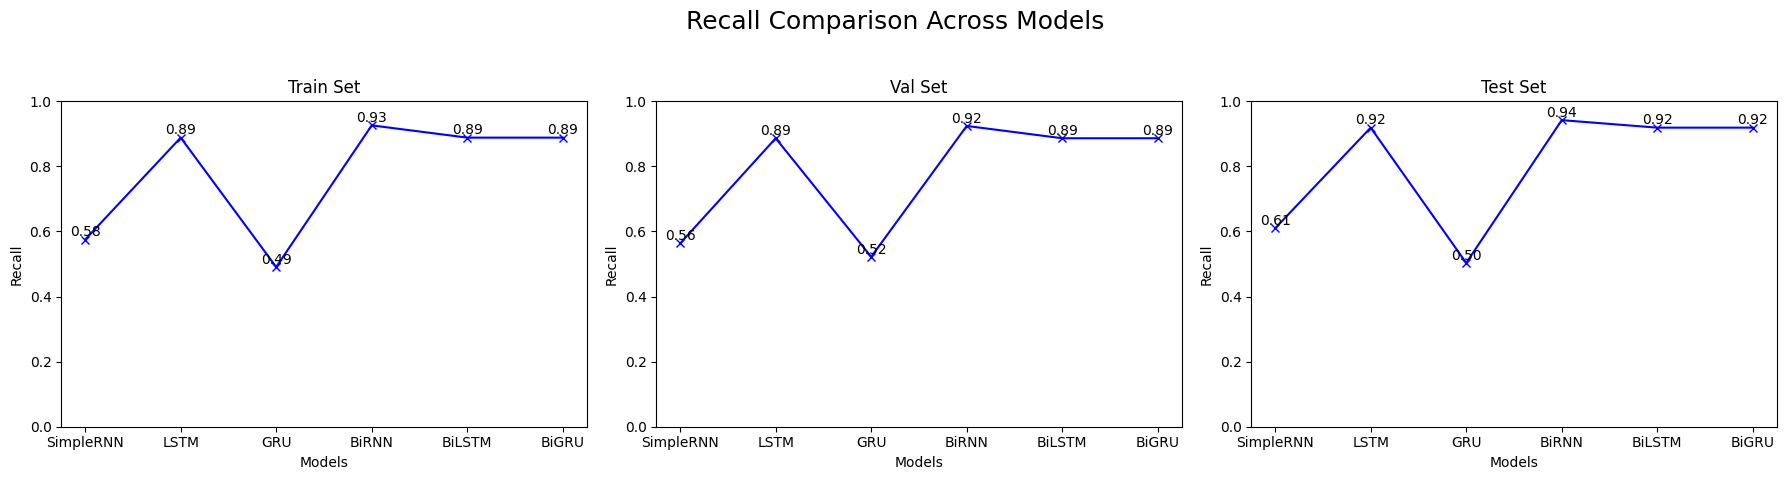

In [44]:
models_results = [simple_rnn_scores, lstm_scores, gru_scores,birnn_scores,bilstm_scores,bigru_scores]
model_names = ['SimpleRNN', 'LSTM', 'GRU','BiRNN','BiLSTM','BiGRU']

plot_model_metrics(models_results, model_names)

# TASK 5: Conv1D Model

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Masking

def build_conv1d_model(input_shape=(1231, 20), num_filters=64, kernel_size=3, pool_size=2, num_classes=3, dropout_rate=0.2):

    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=input_shape))  # Masking for padded sequences

    # 1D Convolutional Layer
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=pool_size))  # Max pooling

    # Second Conv1D Layer
    model.add(Conv1D(filters=num_filters//2, kernel_size=kernel_size, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=pool_size))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model


In [46]:
# Extract only the last time step's label
y_train_fixed = y_train[:, -1, :]  # Shape becomes (batch_size, num_classes)
y_val_fixed = y_val[:, -1, :]
y_test_fixed = y_test[:, -1, :]

In [47]:
# Build the model
model_conv1d = build_conv1d_model(input_shape=(1231, 20), num_classes=3)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_9 (Masking)                  │ (None, 1231, 20)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1231, 64)            │           3,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 615, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 615, 32)             │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 307, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9824)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 9824)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 3)                   │          29,475 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,555 (154.51 KB)

 Trainable params: 39,555 (154.51 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# Train the model with fixed labels
model_conv1d.fit(x_train, y_train_fixed, epochs=8, batch_size=32, validation_data=(x_val, y_val_fixed))


Epoch 1/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.0280 - loss: 6.0574e-04 - val_accuracy: 0.0641 - val_loss: 0.0000e+00
Epoch 2/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.1843 - loss: 0.0093 - val_accuracy: 0.6197 - val_loss: 0.0000e+00
Epoch 3/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - accuracy: 0.3508 - loss: 0.0266 - val_accuracy: 0.1282 - val_loss: 0.0000e+00
Epoch 4/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.3180 - loss: 0.0104 - val_accuracy: 0.0385 - val_loss: 0.0000e+00
Epoch 5/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.2824 - loss: 0.0000e+00 - val_accuracy: 0.7009 - val_loss: 0.0000e+00
Epoch 6/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3607 - loss: 0.0000e+00 - val_accuracy: 0.4573 - val_loss: 0.0000e+00
Epoch 7/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.3532 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 0.0000e+00
Epoch 8/8
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.3418 - lo

In [49]:
conv1d_scores = evaluate_model(model_conv1d, x_train, y_train_fixed, x_val, y_val_fixed, x_test, y_test_fixed)
print_scores(conv1d_scores, title="CONV1D Model Evaluation Metrics")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

CONV1D Model Evaluation Metrics
-------------------------------
train_accuracy  : 0.7017
val_accuracy    : 0.7265
test_accuracy   : 0.7177
train_f1        : 0.8247
val_f1          : 0.8416
test_f1         : 0.8357
train_precision : 1.0000
val_precision   : 1.0000
test_precision  : 1.0000
train_recall    : 0.7017
val_recall      : 0.7265
test_recall     : 0.7177


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Visualize performance of all the models

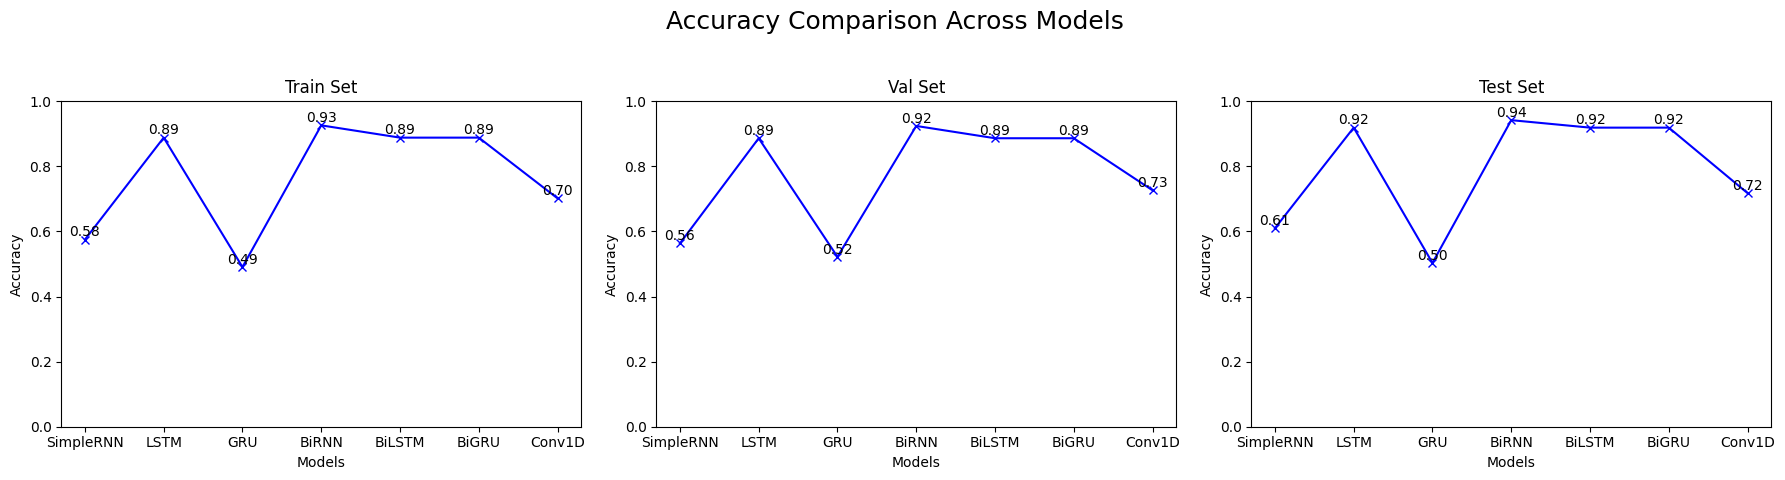

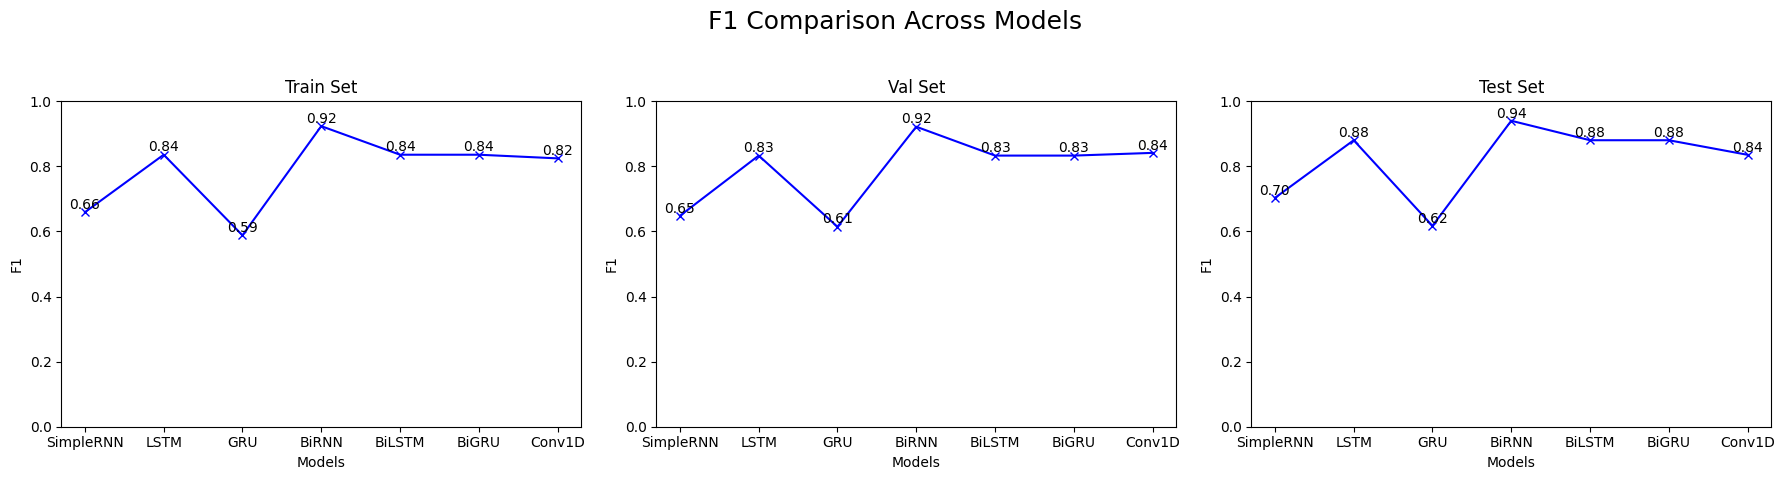

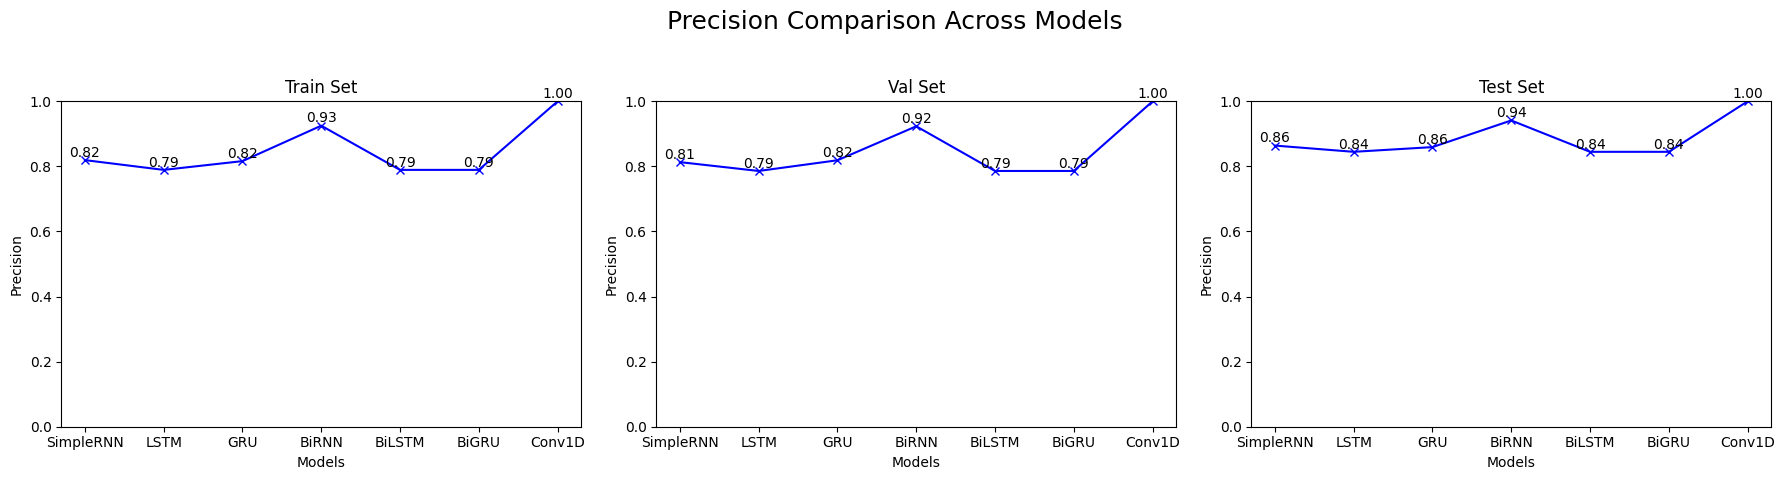

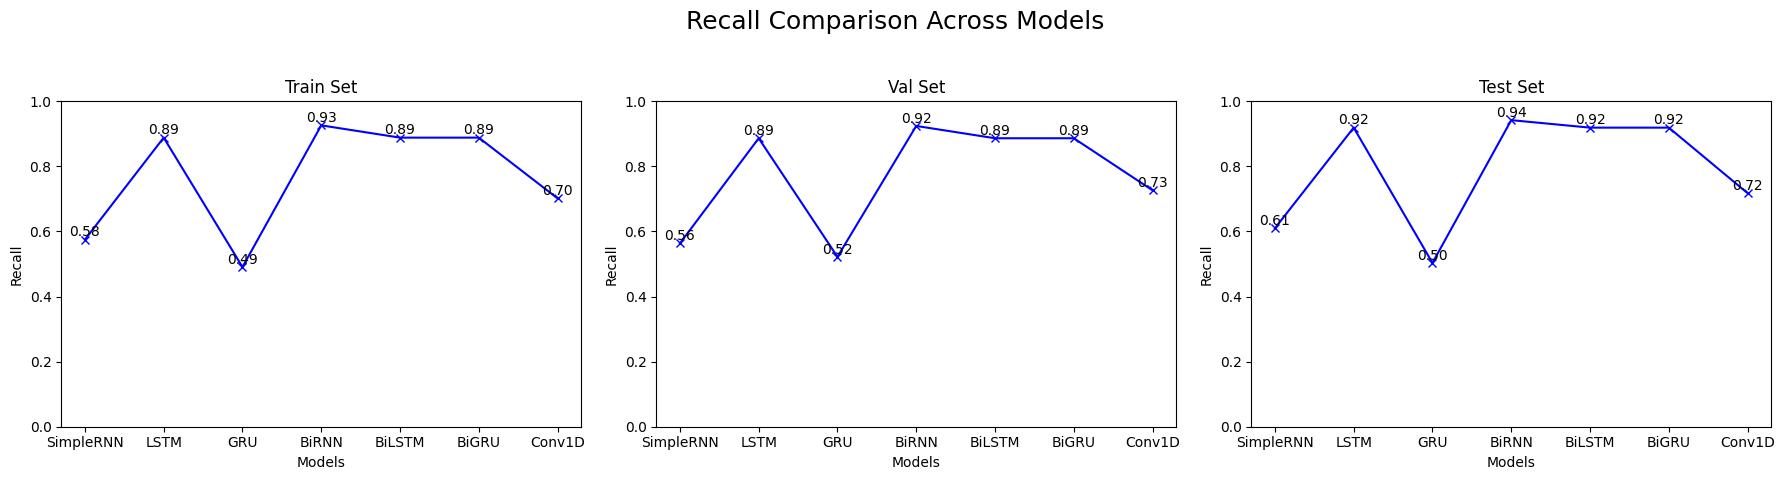

In [50]:
models_results = [simple_rnn_scores, lstm_scores, gru_scores,birnn_scores,bilstm_scores,bigru_scores,conv1d_scores]
model_names = ['SimpleRNN', 'LSTM', 'GRU','BiRNN','BiLSTM','BiGRU','Conv1D']

plot_model_metrics(models_results, model_names)